In [1]:
import sys
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


In [4]:
def get_idomain(nlay, nrow, ncol, lx, lz, fx, fz):
    idomain = np.ones((nlay, nrow, ncol), dtype=np.int)
    x1 = fx * lx
    y1 = lz
    x2 = lx
    y2 = fz * lz
    slope = (y2 - y1) / (x2 - x1)
    b = y1 - slope * x1

    delr = lx / ncol
    delv = lz / nlay
    xcenters = np.linspace(delr/2, lx - delr/2, ncol)
    zcenters = np.linspace(lz - delv / 2, delv/2, nlay)

    for k in range(nlay):
        zc = zcenters[k]
        for j in range(ncol):
            xc = xcenters[j]
            zedge = slope * xc + b
            if zc > zedge:
                idomain[k, 0, j] = 0
                
    kidm0, iidmn0, jidmn0 = np.where(idomain == 0)
    for k, j in zip(kidm0, jidmn0):
        if idomain[k, 0, j] == 0 and idomain[k, 0, j-1] == 1:
            idomain[k, 0, j-1] = 2

    for k, j in zip(kidm0, jidmn0):
        if idomain[k, 0, j] == 0 and idomain[k+1, 0, j] == 1:
            idomain[k+1, 0, j] = 3
                
    return idomain

idomain = get_idomain(10, 1, 20, 2, 1, .5, .5)
plt.figure(figsize=(15, 10))
plt.imshow(idomain[:, 0, :])
plt.colorbar()

In [5]:
def sinfunc(a, b, c, d, x):
    return a * np.sin(b * (x - c)) + d

def get_model(ws, name, nlay=10, ncol=20, 
              lx=2., lz=1., fx=0.5, fz=0.5, 
              sealevel=0.75, amplitude=0.15, frequency=4,
              wellfact=1.0,
              single_matrix=False, hhformulation=True,
              htimes=None, hidx=None, 
              ctimes=None, cidx=None, 
              verbosity_level=1):

    nrow = 1
    delr = lx / ncol
    delc = 1.
    top = lz
    delz = lz / nlay
    botm = list(top - np.arange(delz, nlay * delz + delz, delz))

    perlen = [0.25] + 1000 * [0.001]
    nper = len(perlen)
    nstp = [250] + 1000 * [1]
    tsmult = 1.
    steady = True
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult))
        
    nouter, ninner = 200, 50
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    sim.name_file.continue_ = False
    
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    # --------------------  FLOW --------------------

    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)

    imsgwf = flopy.mf6.ModflowIms(sim, print_option='summary',
                                  csv_output_filerecord=gwfname + '.ims.csv',
                                  complexity='complex',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, 
                                  rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  filename='{}.ims'.format(gwfname), 
                                  no_ptcrecord=True)
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

        
    idomain = get_idomain(nlay, nrow, ncol, lx, lz, fx=fx, fz=fz)
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=idomain)

    # initial conditions
    ic = flopy.mf6.ModflowGwfic(gwf, strt=lz)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=864.)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, sy=0.35, iconvert=1,
                                  steady_state=[False], 
                                  transient=[True])

    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ('LHS')]
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)

    # drn and ghb
    kidx, iidx, jidx = np.where(idomain > 1)
    xcellcenters = gwf.modelgrid.xcellcenters
    zcellcenters = gwf.modelgrid.zcellcenters
    botm = dis.botm.get_data()
    dt = 0.001
    times = np.arange(dt, 1.0 + dt, dt)
    sealevelts = [sealevel] + list(sinfunc(amplitude, frequency * 2 * np.pi, 0, sealevel, times))
    ghbspd = {}
    drnspd = {}
    for kper in range(nper):
        if kper == 0:
            sl = sealevel
        else:
            sl = sealevelts[kper]
        ghblist = []
        drnlist = []
        for k, i, j in zip(kidx, iidx, jidx):
            zcell = zcellcenters[k, i, j]
            cond = 864. * (delz * delc) / (0.5 * delr)
            if zcell > sl:
                drnlist.append([(k, i, j), zcell, 864., 0.])
            else:
                ghblist.append([(k, i, j), sl, 864., 35., 1024.5])
        if len(ghblist) > 0:
            ghbspd[kper] = ghblist
        if len(drnlist) > 0:
            drnspd[kper] = drnlist
    
    # drn
    drn1 = flopy.mf6.ModflowGwfdrn(gwf,
                                   stress_period_data=drnspd,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='DRN-1',
                                   auxiliary='CONCENTRATION')

    # ghb
    ghb1 = flopy.mf6.ModflowGwfghb(gwf,
                                   stress_period_data=ghbspd,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='GHB-1',
                                   auxiliary=['CONCENTRATION', 'DENSITY'])
    
    wellist1 = []
    qwell = 5.7024 * wellfact
    qwell = qwell / nlay
    for k in range(nlay):
        wellist1.append([(k, 0, 0), qwell, 0.])
    wel1 = flopy.mf6.ModflowGwfwel(gwf,
                                   stress_period_data=wellist1,
                                   print_input=True,
                                   print_flows=True,
                                   save_flows=False,
                                   pname='WEL-1',
                                   auxiliary='CONCENTRATION',
                                   filename='{}.wel'.format(gwfname))

    # output control
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('HEAD', 'ALL'),
                                            ('BUDGET', 'ALL')],
                                printrecord=[('HEAD', 'LAST'),
                                             ('BUDGET', 'ALL')])

    # --------------------  TRANSPORT --------------------
    
    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='all',
                                      outer_hclose=hclose,
                                      outer_maximum=10,
                                      inner_maximum=5,
                                      inner_hclose=hclose, 
                                      rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm,
                                  idomain=idomain)

    # initial conditions
    ic = flopy.mf6.ModflowGwtic(gwt, strt=35.,
                                filename='{}.ic'.format(gwtname))

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM',
                                  filename='{}.adv'.format(gwtname))

    # dispersion
    diffc = 0.57024
    dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=diffc,
                                  # alh=0., alv=0., ath=0., atv=0.,
                                  filename='{}.dsp'.format(gwtname))

    # mass storage and transfer
    porosity = 0.35
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity,
                                  filename='{}.mst'.format(gwtname))

    # sources
    sourcerecarray = [('GHB-1', 'AUX', 'CONCENTRATION'),
                      ('WEL-1', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    # fmi
    # this problem does not want to converge unless the flow correction
    # is implemented.  It looks like very small flow errors can wreak
    # havoc on the transport solution.  The correction seems to mitigate
    # these problems and at least keep the solution stable
    fmi = flopy.mf6.ModflowGwtfmi(gwt, flow_imbalance_correction=True)
    
    # output control
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=[('CONCENTRATION', 'ALL')],
                                printrecord=[('CONCENTRATION', 'LAST'),
                                             ('BUDGET', 'ALL')])
    
    # --------------------  EXCHANGE --------------------

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    # --------------------  WRITE AND RUN MODEL --------------------
    
    sim.write_simulation()
    v = sim.run_simulation(report=True, silent=False)
    #for idx in range(-3, 0):
    #    print(v[1][idx])

    # --------------------  LOAD RESULTS --------------------
    
    fname = os.path.join(ws, 'gwf_' + name + '.hds')
    headobj = flopy.utils.HeadFile(fname, precision='double')
    hlist = None
    hts = None
    if htimes is not None:
        times = headobj.get_times()
        hlist = []
        for t in htimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    head = headobj.get_data(totim=tt)
                    hlist.append(head)
                if t.upper() == 'ALL':
                    for tt in times:
                        head = headobj.get_data(totim=tt)
                        hlist.append(head)
            else:
                head = headobj.get_data(totim=t)
                hlist.append(head)

    if hidx is not None:
        hts = headobj.get_ts(hidx)
    headobj.file.close()


    fname = os.path.join(ws, 'gwt_' + name + '.ucn')
    concobj = flopy.utils.HeadFile(fname, text='concentration', precision='double')
    clist = None
    cts = None
    if ctimes is not None:
        times = concobj.get_times()
        clist = []
        for t in ctimes:
            if isinstance(t, str):
                if t.upper() == 'LAST':
                    tt = times[-1]
                    conc = concobj.get_data(totim=tt)
                    clist.append(conc)
                if t.upper() == 'ALL':
                    for tt in times:
                        conc = concobj.get_data(totim=tt)
                        clist.append(conc)
            else:
                conc = concobj.get_data(totim=t)
                clist.append(conc)

    if cidx is not None:
        cts = concobj.get_ts(cidx)
    concobj.file.close()
    
    return sim, hlist, hts, clist, cts

In [6]:
def get_patch_collection(modelgrid, head, conc, cmap='jet', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    botm = modelgrid.botm
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            z0 = zv[k, 0, j]
            z0 = min(z0, head[k, 0, j])
            z0 = max(z0, botm[k, 0, j])
            z1 = zv[k + 1, 0, j]
            poly = [[x0, z0], [x1, z0], [x1, z1], [x0, z1], [x0, z0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor='k', facecolor='red')
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, cmap=cmap, zorder=zorder)
    pc.set_array(conc.flatten())
    return pc

In [7]:
# Hydraulic Head formulation
fx = 0.5
fz = 0.5
lx = 2
lz = 1
sealevel = 0.85
amplitude = 0.14
frequency = 4
wellfact = 0.25

dt = 0.001
times = np.arange(dt, 1.0 + dt, dt)
sealevelts = 250 * [sealevel] + list(sinfunc(amplitude, frequency * 2 * np.pi, 0, sealevel, times))
simtime = np.linspace(dt, 1.25 + dt, 1251)

ws = 'temp/pxx_henry_nr'
name = 'henry'
sim, hlist, hts, clist, cts = get_model(ws, name, nlay=40, ncol=80,
                                        fx=fx, fz=fz, 
                                        sealevel=sealevel, amplitude=amplitude, frequency=frequency,
                                        wellfact=wellfact,
                                        hhformulation=True,
                                        verbosity_level=0,
                                        htimes=['all'],
                                        ctimes=['all'])

FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.5 03/31/2019
                               ***DEVELOP MODE***

  MODFLOW 6 compiled Oct 27 2019 11:58:50 with GFORTRAN compiler (ver. 8.2.0)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorize

 Solving:  Stress period:     1    Time step:   139
 Solving:  Stress period:     1    Time step:   140
 Solving:  Stress period:     1    Time step:   141
 Solving:  Stress period:     1    Time step:   142
 Solving:  Stress period:     1    Time step:   143
 Solving:  Stress period:     1    Time step:   144
 Solving:  Stress period:     1    Time step:   145
 Solving:  Stress period:     1    Time step:   146
 Solving:  Stress period:     1    Time step:   147
 Solving:  Stress period:     1    Time step:   148
 Solving:  Stress period:     1    Time step:   149
 Solving:  Stress period:     1    Time step:   150
 Solving:  Stress period:     1    Time step:   151
 Solving:  Stress period:     1    Time step:   152
 Solving:  Stress period:     1    Time step:   153
 Solving:  Stress period:     1    Time step:   154
 Solving:  Stress period:     1    Time step:   155
 Solving:  Stress period:     1    Time step:   156
 Solving:  Stress period:     1    Time step:   157
 Solving:  S

 Solving:  Stress period:    48    Time step:     1
 Solving:  Stress period:    49    Time step:     1
 Solving:  Stress period:    50    Time step:     1
 Solving:  Stress period:    51    Time step:     1
 Solving:  Stress period:    52    Time step:     1
 Solving:  Stress period:    53    Time step:     1
 Solving:  Stress period:    54    Time step:     1
 Solving:  Stress period:    55    Time step:     1
 Solving:  Stress period:    56    Time step:     1
 Solving:  Stress period:    57    Time step:     1
 Solving:  Stress period:    58    Time step:     1
 Solving:  Stress period:    59    Time step:     1
 Solving:  Stress period:    60    Time step:     1
 Solving:  Stress period:    61    Time step:     1
 Solving:  Stress period:    62    Time step:     1
 Solving:  Stress period:    63    Time step:     1
 Solving:  Stress period:    64    Time step:     1
 Solving:  Stress period:    65    Time step:     1
 Solving:  Stress period:    66    Time step:     1
 Solving:  S

 Solving:  Stress period:   211    Time step:     1
 Solving:  Stress period:   212    Time step:     1
 Solving:  Stress period:   213    Time step:     1
 Solving:  Stress period:   214    Time step:     1
 Solving:  Stress period:   215    Time step:     1
 Solving:  Stress period:   216    Time step:     1
 Solving:  Stress period:   217    Time step:     1
 Solving:  Stress period:   218    Time step:     1
 Solving:  Stress period:   219    Time step:     1
 Solving:  Stress period:   220    Time step:     1
 Solving:  Stress period:   221    Time step:     1
 Solving:  Stress period:   222    Time step:     1
 Solving:  Stress period:   223    Time step:     1
 Solving:  Stress period:   224    Time step:     1
 Solving:  Stress period:   225    Time step:     1
 Solving:  Stress period:   226    Time step:     1
 Solving:  Stress period:   227    Time step:     1
 Solving:  Stress period:   228    Time step:     1
 Solving:  Stress period:   229    Time step:     1
 Solving:  S

 Solving:  Stress period:   371    Time step:     1
 Solving:  Stress period:   372    Time step:     1
 Solving:  Stress period:   373    Time step:     1
 Solving:  Stress period:   374    Time step:     1
 Solving:  Stress period:   375    Time step:     1
 Solving:  Stress period:   376    Time step:     1
 Solving:  Stress period:   377    Time step:     1
 Solving:  Stress period:   378    Time step:     1
 Solving:  Stress period:   379    Time step:     1
 Solving:  Stress period:   380    Time step:     1
 Solving:  Stress period:   381    Time step:     1
 Solving:  Stress period:   382    Time step:     1
 Solving:  Stress period:   383    Time step:     1
 Solving:  Stress period:   384    Time step:     1
 Solving:  Stress period:   385    Time step:     1
 Solving:  Stress period:   386    Time step:     1
 Solving:  Stress period:   387    Time step:     1
 Solving:  Stress period:   388    Time step:     1
 Solving:  Stress period:   389    Time step:     1
 Solving:  S

 Solving:  Stress period:   532    Time step:     1
 Solving:  Stress period:   533    Time step:     1
 Solving:  Stress period:   534    Time step:     1
 Solving:  Stress period:   535    Time step:     1
 Solving:  Stress period:   536    Time step:     1
 Solving:  Stress period:   537    Time step:     1
 Solving:  Stress period:   538    Time step:     1
 Solving:  Stress period:   539    Time step:     1
 Solving:  Stress period:   540    Time step:     1
 Solving:  Stress period:   541    Time step:     1
 Solving:  Stress period:   542    Time step:     1
 Solving:  Stress period:   543    Time step:     1
 Solving:  Stress period:   544    Time step:     1
 Solving:  Stress period:   545    Time step:     1
 Solving:  Stress period:   546    Time step:     1
 Solving:  Stress period:   547    Time step:     1
 Solving:  Stress period:   548    Time step:     1
 Solving:  Stress period:   549    Time step:     1
 Solving:  Stress period:   550    Time step:     1
 Solving:  S

 Solving:  Stress period:   692    Time step:     1
 Solving:  Stress period:   693    Time step:     1
 Solving:  Stress period:   694    Time step:     1
 Solving:  Stress period:   695    Time step:     1
 Solving:  Stress period:   696    Time step:     1
 Solving:  Stress period:   697    Time step:     1
 Solving:  Stress period:   698    Time step:     1
 Solving:  Stress period:   699    Time step:     1
 Solving:  Stress period:   700    Time step:     1
 Solving:  Stress period:   701    Time step:     1
 Solving:  Stress period:   702    Time step:     1
 Solving:  Stress period:   703    Time step:     1
 Solving:  Stress period:   704    Time step:     1
 Solving:  Stress period:   705    Time step:     1
 Solving:  Stress period:   706    Time step:     1
 Solving:  Stress period:   707    Time step:     1
 Solving:  Stress period:   708    Time step:     1
 Solving:  Stress period:   709    Time step:     1
 Solving:  Stress period:   710    Time step:     1
 Solving:  S

 Solving:  Stress period:   853    Time step:     1
 Solving:  Stress period:   854    Time step:     1
 Solving:  Stress period:   855    Time step:     1
 Solving:  Stress period:   856    Time step:     1
 Solving:  Stress period:   857    Time step:     1
 Solving:  Stress period:   858    Time step:     1
 Solving:  Stress period:   859    Time step:     1
 Solving:  Stress period:   860    Time step:     1
 Solving:  Stress period:   861    Time step:     1
 Solving:  Stress period:   862    Time step:     1
 Solving:  Stress period:   863    Time step:     1
 Solving:  Stress period:   864    Time step:     1
 Solving:  Stress period:   865    Time step:     1
 Solving:  Stress period:   866    Time step:     1
 Solving:  Stress period:   867    Time step:     1
 Solving:  Stress period:   868    Time step:     1
 Solving:  Stress period:   869    Time step:     1
 Solving:  Stress period:   870    Time step:     1
 Solving:  Stress period:   871    Time step:     1
 Solving:  S

Text(0, 0.5, 'ELEVATION, IN METERS')

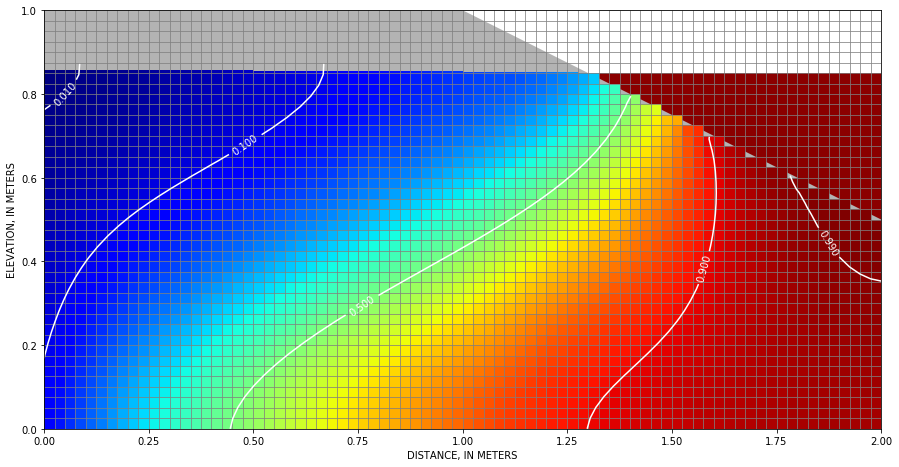

In [8]:
gwf = sim.get_model('gwf_' + name)
botm = gwf.modelgrid.botm
idomain = gwf.modelgrid.idomain
levels = [0.01, .1, .5, .9, .99]

#[249, 311, 436]
itime = len(clist) - 1
conc = clist[itime]
head = hlist[itime]
conc = np.ma.masked_greater(conc, 1e20)
conc = np.ma.masked_where(head < botm, conc)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

sl = sealevelts[itime]
seapoly = np.array([[lx*fx, sl], [lx, sl], [lx, 0]])
patch = matplotlib.patches.Polygon(seapoly, closed=True, facecolor='darkred', zorder=0)
ax.add_patch(patch)

aqpoly = np.array([[0, 0], [lx, 0], [lx, fz*lz], [lx*fx, lz], [0, lz]])
patch = matplotlib.patches.Polygon(aqpoly, closed=True, facecolor='.7', zorder=1)
ax.add_patch(patch)

xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})

pc = get_patch_collection(gwf.modelgrid, head, conc, zorder=2)
pc.set_clim(0, 35.)
ax.add_collection(pc)
xs.plot_grid(linewidths=0.5)

cs = plt.contour(np.flipud(conc[:, 0, :] / 35.), extent=[0, lx, 0, lz], 
                 levels=levels, colors='white', zorder=2)
ax.clabel(cs)
ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS')
#ax.set_title('MODFLOW 6 HYDRAULIC HEAD FORMULATION')

In [9]:
#fname = os.path.join(ws, 'gwf_' + name + '.ims.csv')
#pd.read_csv(fname)

In [10]:
#fname = os.path.join(ws, 'gwf_' + name + '.lst')
#mflst = flopy.utils.Mf6ListBudget(fname)
#dfi, dfc = mflst.get_dataframes(start_datetime=None)

#plt.figure(figsize=(10, 5))
#ax = plt.subplot(1, 1, 1)
#dfi.plot(ax=ax, y=['TOTAL_IN', 'GHB_IN', 'DRN_OUT'])

In [11]:
# export figures in order to make an animation
gwf = sim.get_model('gwf_' + name)
botm = gwf.modelgrid.botm
idomain = gwf.modelgrid.idomain
levels = [0.01, .1, .5, .9, .99]

ws = './temp/pxx_henry_nr'
figdir = os.path.join(ws, 'figs')
if os.path.isdir(figdir):
    shutil.rmtree(figdir)
os.mkdir(figdir)

if False:
    for ifig, itime in enumerate(range(0, 1250, 1)):
        conc = clist[itime]
        head = hlist[itime]
        conc = np.ma.masked_greater(conc, 1e20)
        conc = np.ma.masked_where(head < botm, conc)

        fig = plt.figure(figsize=(15,9))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')

        sl = sealevelts[itime]
        seapoly = np.array([[lx*fx, sl], [lx, sl], [lx, 0]])
        patch = matplotlib.patches.Polygon(seapoly, closed=True, facecolor='darkred', zorder=0)
        ax.add_patch(patch)

        aqpoly = np.array([[0, 0], [lx, 0], [lx, fz*lz], [lx*fx, lz], [0, lz]])
        patch = matplotlib.patches.Polygon(aqpoly, closed=True, facecolor='.7', zorder=1)
        ax.add_patch(patch)

        xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0})

        pc = get_patch_collection(gwf.modelgrid, head, conc, zorder=2)
        pc.set_clim(0, 35.)
        ax.add_collection(pc)

        xs.plot_grid(linewidths=0.5)

        cs = plt.contour(np.flipud(conc[:, 0, :] / 35.), extent=[0, lx, 0, lz], 
                         levels=levels, colors='white', zorder=2)
        ax.clabel(cs)
        ax.set_xlabel('DISTANCE, IN METERS')
        ax.set_ylabel('ELEVATION, IN METERS')
        ttl = 'TIME = {:.3f} days'.format(simtime[itime])
        ax.set_title(ttl)
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(figdir, fname)
        print('{}: saving {}, {}'.format(ifig, fname, ttl))
        plt.savefig(fname)
        plt.close(fig)

In [12]:
# Use ffmpeg to make an animation
if False:
    from subprocess import check_output
    figfile = os.path.join(figdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vcodec', 'libx264',
                           '-pix_fmt', 'yuv420p',
                           anmfile])

In [13]:
# make vtu files
from flopy.export.vtk import Vtk

ws = './temp/pxx_henry_nr'
figdir = os.path.join(ws, 'vtu')
if os.path.isdir(figdir):
    shutil.rmtree(figdir)
os.mkdir(figdir)

gwf = sim.get_model('gwf_' + name)
idomain = gwf.modelgrid.idomain
top = gwf.dis.top.get_data()
botm = gwf.modelgrid.botm
delr = gwf.dis.delr.get_data()
delc = gwf.dis.delc.get_data()
nlay, nrow, ncol = botm.shape

dt = 0.001
times = np.linspace(dt, 1.25 + dt, 1251)

if False:
    for ifig, i in enumerate(range(0, 1250, 100)):
        print(i)

        tm = times[i]

        head = hlist[i]
        ibound = np.ones(botm.shape, dtype=np.int)
        ibound = np.where(head < botm, 0, ibound)
        ibound = np.where(head >= 1.e30, 0, ibound)
        ibound = np.where(idomain < 1, 0, ibound)

        mf5 = flopy.modflow.Modflow()
        dis5 = flopy.modflow.ModflowDis(mf5, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,
                                       top=top, botm=botm)
        bas5 = flopy.modflow.ModflowBas(mf5, ibound=ibound)

        tp = np.vstack((top.reshape(1, nrow, ncol), botm[:-1]))
        htop = head.copy()
        htop = np.where(htop > tp, tp, htop)
        htop = np.where(htop < botm, botm, htop)

        conc = clist[i]

        fname = 'model-conc-{}.vtu'.format(ifig)
        fname = os.path.join(figdir, fname)
        vtk = Vtk(fname, model=mf5)
        vtk.add_array('CONCENTRATION', conc)
        vtk.write(ibound_filter=True, htop=htop)

### Boundary Conditon Plot

In [14]:
def get_colored_patch_collection(modelgrid, ibd, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    botm = modelgrid.botm
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            if ibd[k, j] == 1:
                x0 = xv[0, j]
                x1 = xv[0, j + 1]
                z0 = zv[k, 0, j]
                z1 = zv[k + 1, 0, j]
                poly = [[x0, z0], [x1, z0], [x1, z1], [x0, z1], [x0, z0]]
                #print(poly)
                patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
                patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True)
    return pc

inwidth 3.248031496062992


/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


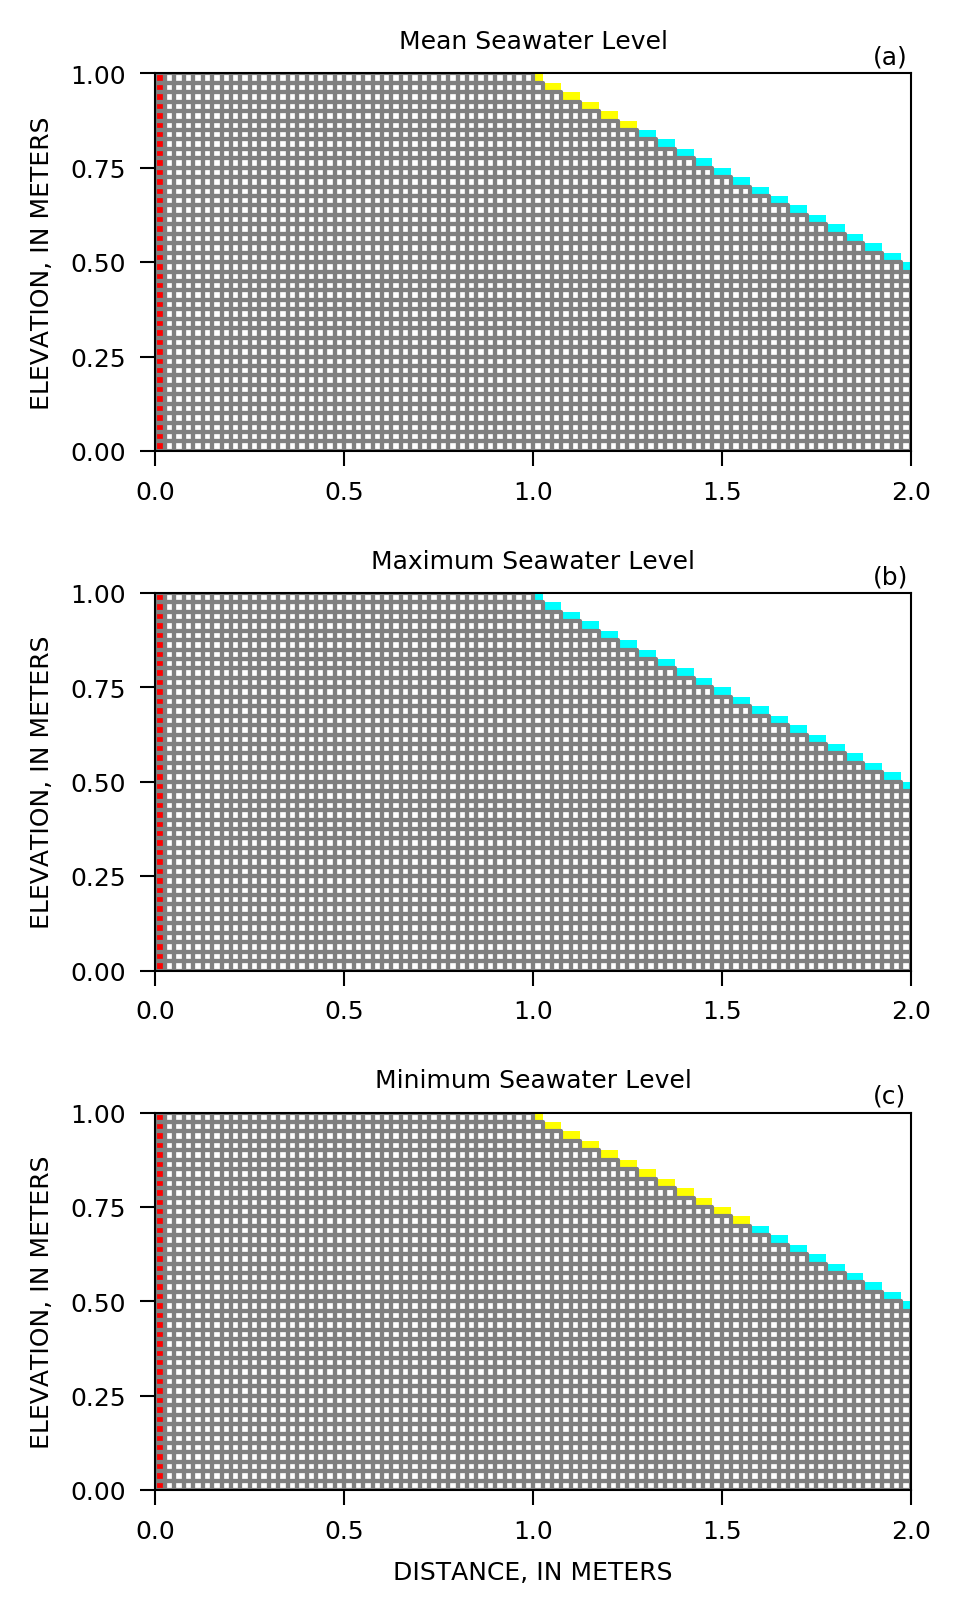

In [15]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, .5, 1., 1.5, 2.])
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)

gwf = sim.get_model('gwf_' + name)
modelgrid = gwf.modelgrid
nlay = modelgrid.nlay
ncol = modelgrid.ncol

ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[:, 0] = 1
pc_well = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='red')

ibd = np.where(idomain[:, 0, :] == 1, 1, 0)
pc_grd = get_colored_patch_collection(modelgrid, ibd, ec='gray', fc='none')

ibd = np.zeros((nlay, ncol), dtype=np.int)
for k, i, j in gwf.drn.stress_period_data.get_data()[0]['cellid']:
    ibd[k, j] = 1
pc_drn = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='yellow')

ibd = np.zeros((nlay, ncol), dtype=np.int)
for k, i, j in gwf.ghb.stress_period_data.get_data()[0]['cellid']:
    ibd[k, j] = 1
pc_ghb = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='cyan')

ax = fig.add_subplot(3, 1, 1, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
#xs.plot_grid(linewidths=0.5, alpha=0.5)
pcb = ax.add_collection(pc_ghb)
pcd = ax.add_collection(pc_drn)
pcw = ax.add_collection(pc_well)
pcg = ax.add_collection(pc_grd)
#ax.set_xlabel('DISTANCE, IN METERS')
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.set_title('Mean Seawater Level', fontsize=6)
#ax.legend([pcw, pcc], ['Freshwater Inflow', 'Seawater Hydrostatic Conditions'])
ax.text(1.9, 1.025, '(a)', fontsize=6)

kpertsmax = np.argmax(sealevelts)
ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[:, 0] = 1
pc_well = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='red')

ibd = np.where(idomain[:, 0, :] == 1, 1, 0)
pc_grd = get_colored_patch_collection(modelgrid, ibd, ec='gray', fc='none')

ibd = np.zeros((nlay, ncol), dtype=np.int)
drnspd = gwf.drn.stress_period_data.get_data()
if kpertsmax in drnspd:
    for k, i, j in drnspd[kpertsmax]['cellid']:
        ibd[k, j] = 1
pc_drn = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='yellow')

ibd = np.zeros((nlay, ncol), dtype=np.int)
for k, i, j in gwf.ghb.stress_period_data.get_data()[kpertsmax]['cellid']:
    ibd[k, j] = 1
pc_ghb = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='cyan')


ax = fig.add_subplot(3, 1, 2, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
#xs.plot_grid(linewidths=0.5, alpha=0.5)
pcb = ax.add_collection(pc_ghb)
pcd = ax.add_collection(pc_drn)
pcw = ax.add_collection(pc_well)
pcg = ax.add_collection(pc_grd)
#ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.set_title('Maximum Seawater Level', fontsize=6)
ax.text(1.9, 1.025, '(b)', fontsize=6)

kpertsmin = np.argmin(sealevelts)
ibd = np.zeros((nlay, ncol), dtype=np.int)
ibd[:, 0] = 1
pc_well = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='red')

ibd = np.where(idomain[:, 0, :] == 1, 1, 0)
pc_grd = get_colored_patch_collection(modelgrid, ibd, ec='gray', fc='none')

ibd = np.zeros((nlay, ncol), dtype=np.int)
drnspd = gwf.drn.stress_period_data.get_data()
if kpertsmin in drnspd:
    for k, i, j in gwf.drn.stress_period_data.get_data()[kpertsmin]['cellid']:
        ibd[k, j] = 1
pc_drn = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='yellow')

ibd = np.zeros((nlay, ncol), dtype=np.int)
for k, i, j in gwf.ghb.stress_period_data.get_data()[kpertsmin]['cellid']:
    ibd[k, j] = 1
pc_ghb = get_colored_patch_collection(modelgrid, ibd, ec='none', fc='cyan')


ax = fig.add_subplot(3, 1, 3, aspect='equal')
ax_formatter(ax)
xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)
#xs.plot_grid(linewidths=0.5, alpha=0.5)
pcb = ax.add_collection(pc_ghb)
pcd = ax.add_collection(pc_drn)
pcw = ax.add_collection(pc_well)
pcg = ax.add_collection(pc_grd)
ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
ax.set_title('Minimum Seawater Level', fontsize=6)
ax.text(1.9, 1.025, '(c)', fontsize=6)


fname = '../Figures/pxx_henrynr_bcs.pdf'
plt.savefig(fname, bbox_inches='tight')

# Seawater Level versus time plot

inwidth 3.248031496062992


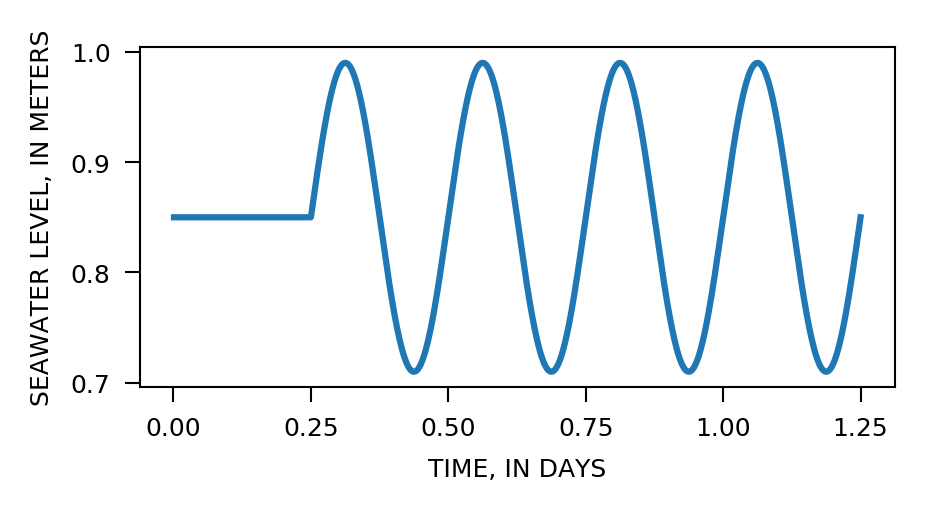

In [16]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 1.5), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax_formatter(ax)
ax.plot(np.arange(dt, 1.25 + dt, dt), sealevelts)
ax.set_xlabel('TIME, IN DAYS', fontsize=6)
ax.set_ylabel('SEAWATER LEVEL, IN METERS', fontsize=6)
fname = '../Figures/pxx_henrynr_sealevel.pdf'
plt.savefig(fname, bbox_inches='tight')

## Results Plot

inwidth 3.248031496062992


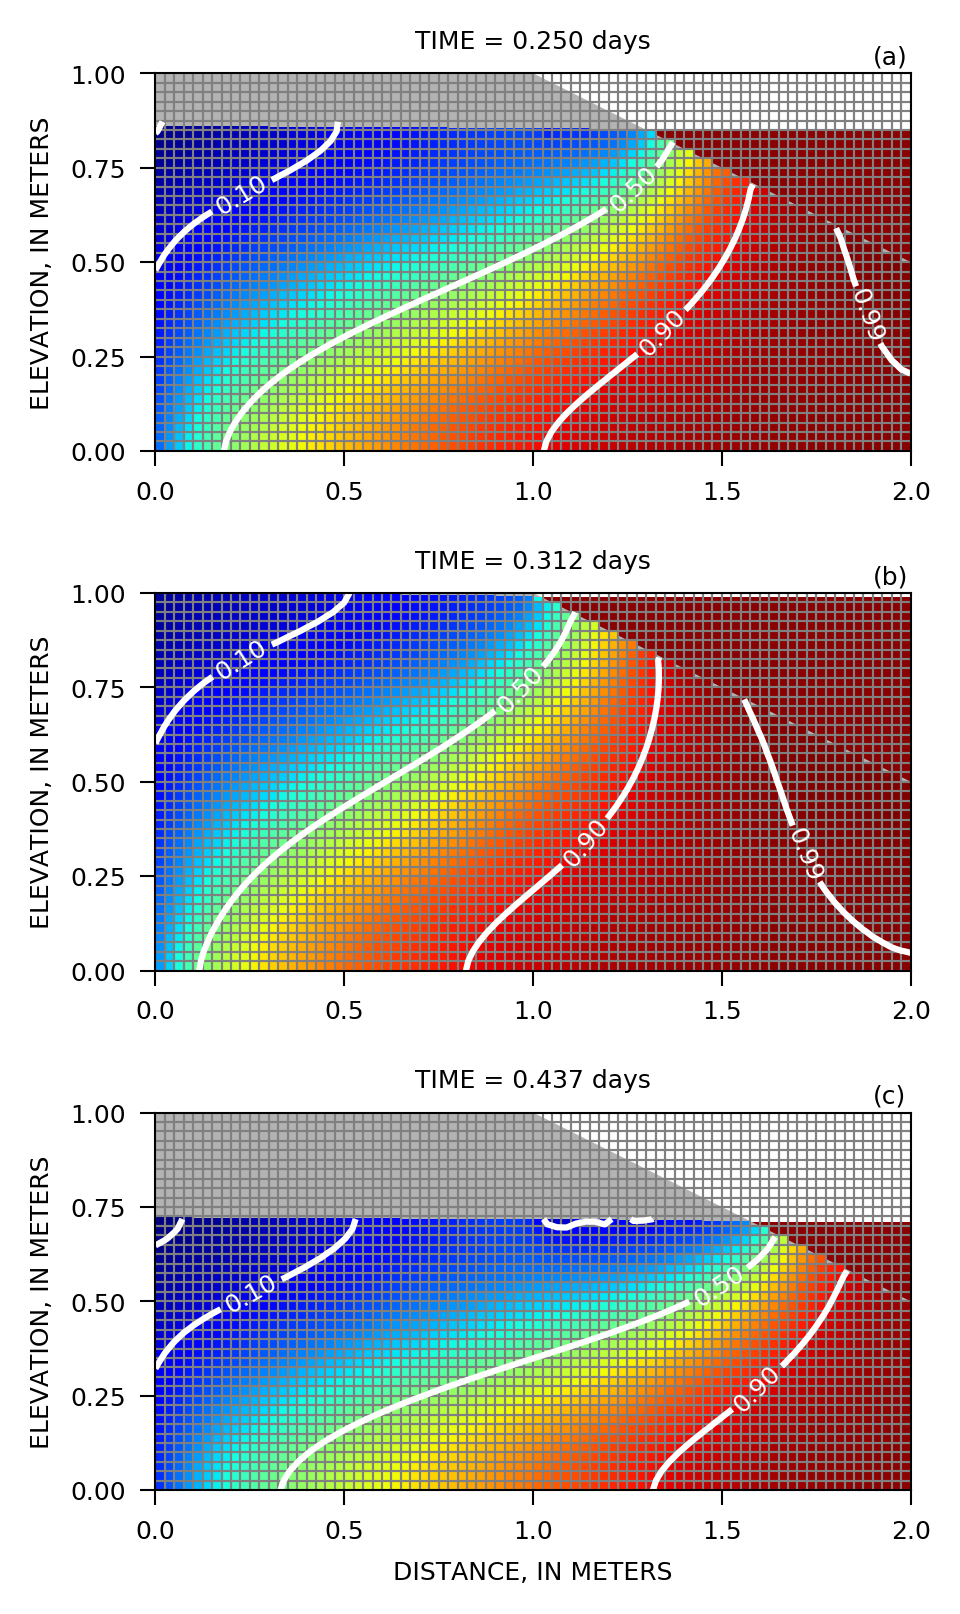

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def ax_formatter(ax):
    for tick in ax.xaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')    
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontsize(6)
        tick.set_fontname('Helvetica')
        tick.set_color('black')
        tick.set_weight('normal')
    ax.set_aspect(1.)
    ax.set_xticks([0, .5, 1., 1.5, 2.])
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)

cmwidth = 8.25 # Groundwater 1 column width figure size
inwidth = cmwidth / 2.54
print('inwidth {}'.format(inwidth))
fig = plt.figure(figsize=(inwidth, 6.5), dpi=300)


# export figures in order to make an animation
gwf = sim.get_model('gwf_' + name)
botm = gwf.modelgrid.botm
idomain = gwf.modelgrid.idomain
levels = [0.01, .1, .5, .9, .99]

ws = './temp/pxx_henry_nr'
figdir = os.path.join(ws, 'figs')
if os.path.isdir(figdir):
    shutil.rmtree(figdir)
os.mkdir(figdir)

times2plot = [249, np.argmax(sealevelts), np.argmin(sealevelts)]
nplots = len(times2plot)

figtxt = ['(a)', '(b)', '(c)']

for ifig, itime in enumerate(times2plot):
    conc = clist[itime]
    head = hlist[itime]
    conc = np.ma.masked_greater(conc, 1e20)
    conc = np.ma.masked_where(head < botm, conc)

    ax = fig.add_subplot(nplots, 1, ifig + 1, aspect='equal')
    ax_formatter(ax)
    
    sl = sealevelts[itime]
    seapoly = np.array([[lx*fx, sl], [lx, sl], [lx, 0]])
    patch = matplotlib.patches.Polygon(seapoly, closed=True, facecolor='darkred', zorder=0)
    ax.add_patch(patch)

    aqpoly = np.array([[0, 0], [lx, 0], [lx, fz*lz], [lx*fx, lz], [0, lz]])
    patch = matplotlib.patches.Polygon(aqpoly, closed=True, facecolor='.7', zorder=1)
    ax.add_patch(patch)

    xs = flopy.plot.PlotCrossSection(gwf, line={'row': 0}, ax=ax)

    pc = get_patch_collection(gwf.modelgrid, head, conc, zorder=2)
    pc.set_clim(0, 35.)
    ax.add_collection(pc)
    
    xs.plot_grid(linewidths=0.5)

    cs = plt.contour(np.flipud(conc[:, 0, :] / 35.), extent=[0, lx, 0, lz], 
                     levels=levels, colors='white', zorder=2)
    ax.clabel(cs, fontsize=6, fmt='%1.2f')
    if ifig == nplots - 1:
        ax.set_xlabel('DISTANCE, IN METERS', fontsize=6)
    ax.set_ylabel('ELEVATION, IN METERS', fontsize=6)
    ttl = 'TIME = {:.3f} days'.format(simtime[itime])
    ax.set_title(ttl, fontsize=6)
    ax.text(1.9, 1.025, figtxt[ifig], fontsize=6)
    
fname = '../Figures/pxx_henrynr_results.pdf'
plt.savefig(fname, bbox_inches='tight')